In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
from pathlib import Path
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tqdm.auto import tqdm

from kerastuner import tuners
from kerastuner import HyperParameters

import captchanet

data_dir = Path('/home/hadim/.data/Neural_Network/captchanet')
dataset_dir = data_dir / 'dataset'

train_data_path = dataset_dir / 'training.tfrecord'
val_data_path = dataset_dir / 'validation.tfrecord'

tokenizer_path = dataset_dir / "tokenizer"

log_dir = data_dir / 'log'
log_dir.mkdir(exist_ok=True, parents=True)

model_dir = data_dir / 'model'
model_dir.mkdir(exist_ok=True, parents=True)
  
# Get tokenizer
tokenizer = tfds.features.text.TokenTextEncoder.load_from_file(str(tokenizer_path))

In [2]:
# Build the dataset
def make_dataset(data_path, tokenizer, batch_size=10, shuffle=False, n=None):

  dataset = tf.data.TFRecordDataset(str(data_path))
  if n:
    dataset = dataset.take(n)
  if shuffle:
      dataset = dataset.shuffle(buffer_size=10000)
      
  # We could infer it from the dataset but here it's hard-coded.
  max_len_word = 10
      
  decode_fn = captchanet.decode_data(tokenizer, max_len_word)
  dataset = dataset.map(map_func=decode_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

batch_size = 64
train_dataset = make_dataset(train_data_path, tokenizer, batch_size=batch_size, shuffle=True)
val_dataset = make_dataset(val_data_path, tokenizer, batch_size=batch_size, shuffle=False)

W0701 19:44:51.219838 140561851197248 deprecation.py:323] From /home/hadim/conda/envs/captchanet/lib/python3.7/site-packages/tensorflow/python/ops/image_ops_impl.py:1511: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [3]:
def build_model(image_shape, image_type, vocabulary_size, max_len_word, params=None):

  def _builder(hp):

    kernel_size = (3, 3)
    pool_size = (2, 2)
    activation = 'relu'

    n_layers = hp.Range('n_layers', min_value=2, max_value=6, step=1, default=5)
    n_conv = hp.Range('n_conv', min_value=1, max_value=6, step=1, default=2)
    n_base_filters = hp.Choice('n_base_filters', values=[8, 16, 32], default=8)

    kernel_initializer = hp.Choice('kernel_initializer', values=['glorot_uniform', 'he_normal', 'he_uniform'], default='he_uniform')
    use_dense_layer = hp.Choice('use_dense_layer', values=['yes', 'no'], default='yes')
    dense_units = hp.Choice('dense_units', values=[512, 1024, 2048], default=2048)

    optimizer_name = hp.Choice('optimizer_name', values=['sgd', 'adam', 'rmsprop'], default='rmsprop')
    starting_lr = hp.Choice('starting_lr', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5], default=1e-3)
    momentum = hp.Choice('momentum', values=[0.9, 0.95, 0.99], default=0.9)

    tf.keras.backend.clear_session()

    inputs = tf.keras.layers.Input(name='image', shape=image_shape, dtype=image_type)
    x = inputs

    for i in range(n_layers):
      n_filters = n_base_filters * 2 ** min(i, 4)
      for _ in range(n_conv):
        x = tf.keras.layers.Conv2D(n_filters, kernel_size, padding='same', kernel_initializer=kernel_initializer)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(activation)(x)
      x = tf.keras.layers.MaxPooling2D(pool_size)(x)
      x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Flatten()(x)

    if use_dense_layer == 'yes':
      x = tf.keras.layers.Dense(dense_units)(x)
      x = tf.keras.layers.Activation(activation)(x)
      x = tf.keras.layers.Dropout(0.7)(x)

    outputs = []
    for i in range(max_len_word):
      out = tf.keras.layers.Dense(vocabulary_size, activation='softmax', name=f'character_{i}')(x)
      outputs.append(out)
    outputs = tf.keras.layers.Concatenate()(outputs)
    outputs = tf.keras.layers.Reshape((max_len_word, vocabulary_size))(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Optimizer Parameters
    sgd_params = {}
    sgd_params['learning_rate'] = starting_lr
    sgd_params['momentum'] = momentum
    sgd_params['nesterov'] = True

    adam_params = {}
    adam_params['learning_rate'] = starting_lr
    adam_params['amsgrad'] = True

    rmsprop_params = {}
    rmsprop_params['learning_rate'] = starting_lr

    # Build optimizer.
    if optimizer_name == 'sgd':
      optimizer = tf.keras.optimizers.SGD(**sgd_params)
    elif optimizer_name == 'adam':
      optimizer = tf.keras.optimizers.Adam(**adam_params)
    elif optimizer_name == 'rmsprop':
      optimizer = tf.keras.optimizers.RMSprop(**rmsprop_params)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

  hp = HyperParameters()

  if params:
    for key, value in params.items():
      hp.Fixed(key, value)

  return _builder(hp)

In [ ]:
# Get image shape
image, label = [d for d in train_dataset.take(1)][0]
image_shape = image.shape[1:]
image_type = image.dtype

params = {}

params['n_layers'] = 5
params['n_conv'] = 2
params['n_base_filters'] = 8
params['kernel_initializer'] = 'he_uniform'
params['use_dense_layer'] = 'yes'
params['dense_units'] = 2048
params['optimizer_name'] = 'rmsprop'
params['starting_lr'] = 1e-3
params['momentum'] = 0.9

# Build the model.
# Also available at `captchanet.build_model`.
model = build_model(image_shape, image_type, tokenizer.vocab_size, max_len_word=10, params=params)

# Callbacks
callbacks = []

log_path = log_dir / datetime.datetime.now().strftime("%Y.%m.%d-%H.%M.%S")
tb = captchanet.LRTensorBoard(log_dir=str(log_path), write_images=True, write_graph=True)
callbacks.append(tb)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
callbacks.append(reduce_lr)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=1e-6, patience=20)
callbacks.append(early_stop)

tqdm_progress = captchanet.TQDMCallback()
callbacks.append(tqdm_progress)

csv_logger = tf.keras.callbacks.CSVLogger(str(log_path / 'log.csv'))
callbacks.append(csv_logger)

n_epochs = 1000
model.fit(train_dataset, validation_data=val_dataset, epochs=n_epochs, callbacks=callbacks, verbose=0)

# Save model
model_path = model_dir / log_path.stem
model_path.mkdir(exist_ok=True)
model.save(str(model_path / 'model.h5'))

# Save tokenizer
tokenizer.save_to_file(str(model_path / 'tokenizer'))

# Save history
history = pd.DataFrame(model.history.history)
history.to_csv(str(model_path / 'tokenizer'))

W0701 19:44:55.352661 140561851197248 nn_ops.py:4220] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


W0701 19:44:55.995970 140561851197248 deprecation.py:323] From /home/hadim/conda/envs/captchanet/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Text(0.5, 0, 'epoch')

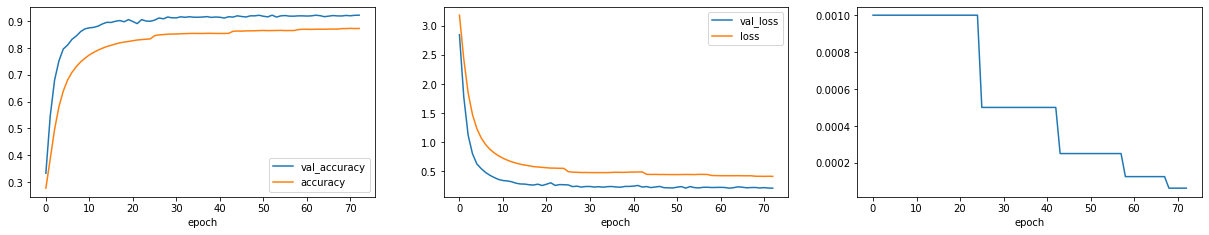

In [5]:
# Check history

#hist = model.history.history
history = pd.read_csv(history_path)

n = 3
size = 3.5
ncols = 3
w_h_scale = 2
figsize = (ncols * size * w_h_scale, size)
fig, axs = plt.subplots(nrows=n//ncols, ncols=ncols, figsize=figsize)
axs = axs.flatten()

axs[0].plot(history['val_accuracy'], label='val_accuracy')
axs[0].plot(history['accuracy'], label='accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend()

axs[1].plot(history['val_loss'], label='val_loss')
axs[1].plot(history['loss'], label='loss')
axs[1].set_xlabel('epoch')
axs[1].legend()

axs[2].plot(history['lr'])
axs[2].set_xlabel('epoch')

W0701 22:49:31.736173 140561851197248 nn_ops.py:4220] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


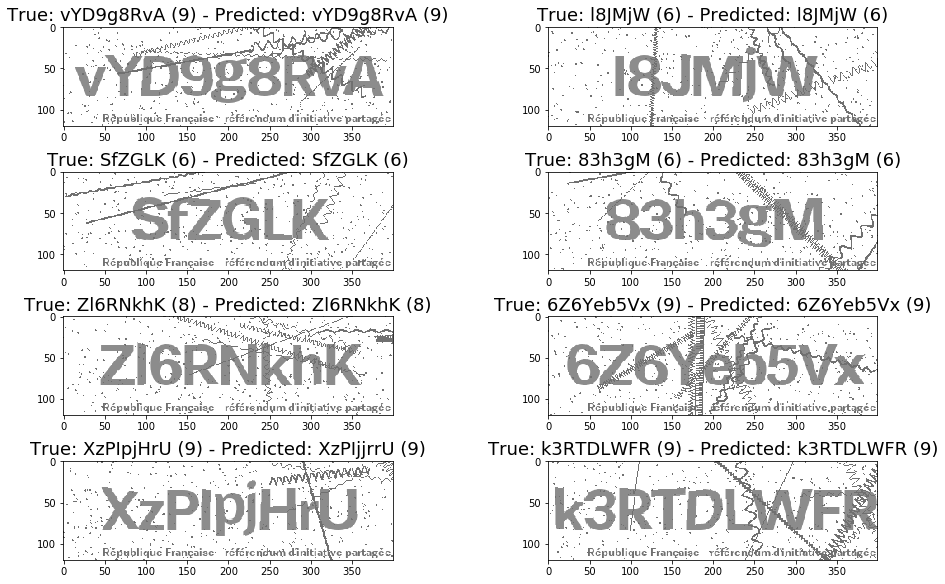

In [7]:
# Load model
model_name = 'v1'
model_name = log_path.stem
model_path = model_dir / model_name / 'model.h5'

loaded_model = tf.keras.models.load_model(str(model_path))

# Perform prediction
n  = 8
dataset = tf.data.TFRecordDataset(str(val_data_path))
dataset = dataset.map(map_func=captchanet.decode_data(tokenizer, max_len_word=10, input_as_dict=True))
dataset = dataset.shuffle(1024)
dataset = dataset.batch(n)
data = [d for d in dataset.take(1)][0]

images = data['image']
labels = data['label']

labels = loaded_model(images)

# Decode
labels = labels.numpy().argmax(axis=2)
predicted_words = [tokenizer.decode(label) for label in labels]
predicted_words = [word.replace(' ', '').replace('0', '') for word in predicted_words]

# Plot
original_images = data['original_image'].numpy()
words = data['word'].numpy()
words = [w.decode('utf-8').replace('0', '') for w in words]

size = 2
ncols = 2
nrows = n // ncols
ratio = images.shape[2] / images.shape[1]
figsize = (ncols * size * ratio, size * nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
axs = axs.flatten()

for image, word, predicted_word, ax in zip(original_images, words, predicted_words, axs):
  ax.imshow(image)
  
  text = f'True: {word} ({len(word)}) - '
  text += f'Predicted: {predicted_word} ({len(predicted_word)})'
  ax.set_title(text, fontsize=18)

In [8]:
# Measure performance of the model

# Load model
model_name = 'v1'
model_name = log_path.stem
model_path = model_dir / model_name / 'model.h5'

loaded_model = tf.keras.models.load_model(str(model_path))

data = pd.DataFrame()

for images, true_labels in tqdm(val_dataset):
  labels = model(images)

  labels = labels.numpy().argmax(axis=2)
  labels = [tokenizer.decode(label) for label in labels]
  labels = [word.replace(' ', '').replace('0', '') for word in labels]

  true_labels = true_labels.numpy().argmax(axis=2)
  true_labels = [tokenizer.decode(label) for label in true_labels]
  true_labels = [word.replace(' ', '').replace('0', '') for word in true_labels]
  
  datum = {}
  datum['correct_prediction'] = [true_label == label for true_label, label in zip(true_labels, labels)]
  datum['len_word'] = [len(true_label) for true_label in true_labels]
  
  data = pd.concat([data, pd.DataFrame(datum)], ignore_index=True)
  
data = data.reset_index(drop=True)

correct_prediction_ratio = data['correct_prediction'].sum() / data.shape[0]

# Percentage of correctly predicted captcha.
correct_prediction_ratio

W0701 22:49:54.064992 140561851197248 nn_ops.py:4220] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


0.61185

## Hyperparameter Search

In [ ]:
max_trials = 10000
search_dir = log_dir / "hyperparam_search"
tuner = tuners.RandomSearch(build_model, objective='val_accuracy', max_trials=max_trials,
                            executions_per_trial=1, directory=str(search_dir), project_name='search2')
tuner.search_space_summary()

# Callbacks
callbacks = []

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
callbacks.append(reduce_lr)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=5e-3, patience=20)
callbacks.append(early_stop)

n_epochs = 200
tuner.search(train_dataset, validation_data=val_dataset, epochs=n_epochs, callbacks=callbacks, verbose=0)